In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# =============================================
# Preparación del dataset Imagewoof para colorización
# =============================================
import os
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.color import rgb2lab, lab2rgb
from PIL import Image
import matplotlib.pyplot as plt
from utils.utils import ImagewoofColorizationDataset




In [3]:
DATA_DIR = Path("imagewoof2-160")  


# ---------------------------------------------
# Crear datasets
# ---------------------------------------------
train_dataset = ImagewoofColorizationDataset(DATA_DIR, split="train")
val_dataset   = ImagewoofColorizationDataset(DATA_DIR, split="val")

# ---------------------------------------------
# Crear DataLoaders (sin multiprocessing)
# ---------------------------------------------
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)


In [4]:


print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

# ---------------------------------------------
# Probar una muestra del DataLoader
# ---------------------------------------------
L_batch, ab_batch = next(iter(train_loader))
print("Shape canal L:", L_batch.shape)   # [batch, 1, H, W]
print("Shape canales ab:", ab_batch.shape)  # [batch, 2, H, W]


Train samples: 9025
Val samples: 3929
Shape canal L: torch.Size([16, 1, 224, 224])
Shape canales ab: torch.Size([16, 2, 224, 224])


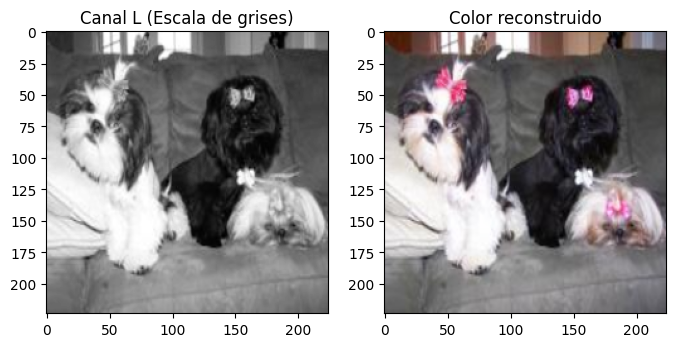

In [5]:
# ---------------------------------------------
# Visualizar una muestra reconstruida (opcional)
# ---------------------------------------------
L_sample = L_batch[0]
ab_sample = ab_batch[0]

# Reconstruir imagen RGB aproximada
lab = torch.cat((L_sample, ab_sample), dim=0).permute(1, 2, 0).numpy()
rgb = lab2rgb(lab * [100, 128, 128])

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(L_sample.squeeze(), cmap='gray')
plt.title("Canal L (Escala de grises)")

plt.subplot(1,2,2)
plt.imshow(rgb)
plt.title("Color reconstruido")
plt.show()


ENCODER

In [6]:
import torch.optim as optim
from tqdm import tqdm
from models.encoder import FastColorNet
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando:", device)

# Redimensionar imágenes a 128×128 para acelerar
train_dataset = ImagewoofColorizationDataset(DATA_DIR, img_size=128, split="train")
val_dataset   = ImagewoofColorizationDataset(DATA_DIR, img_size=128, split="val")

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)
        

Usando: cpu


In [9]:
from utils.trainer import trainer


# Configuración del modelo y ruta
model = FastColorNet()
save_path = "pesos_entrenados"
save_name = "fastColorNet.pt"
model_path = Path(save_path) / save_name

train= False  # Cambia a True para forzar el reentrenamiento

# Verificar si ya existe un modelo entrenado
if model_path.exists and not train:
    print(f"✅ Modelo ya entrenado encontrado en '{model_path}'.")
    print("No se vuelve a entrenar para evitar sobreescritura.")
else:
    print("🚀 No se encontró modelo entrenado, iniciando entrenamiento...")
    trainer(
        model,
        train_loader,
        val_loader,
        epochs=10,
        save_path=save_path,
        save_name=save_name
    )
    print(f"💾 Modelo guardado en: {model_path}")

🚀 No se encontró modelo entrenado, iniciando entrenamiento...
Entrenando en: cpu
Usando pérdida: L1Loss


Época 1/10: 100%|██████████| 1129/1129 [01:25<00:00, 13.21it/s, loss=0.0303]


Época 01 | Train Loss: 0.0670 | Val Loss: 0.0661
✅ Nuevo mejor modelo guardado (Val Loss=0.0661)


Época 2/10: 100%|██████████| 1129/1129 [01:25<00:00, 13.18it/s, loss=0.0719]


Época 02 | Train Loss: 0.0660 | Val Loss: 0.0651
✅ Nuevo mejor modelo guardado (Val Loss=0.0651)


Época 3/10: 100%|██████████| 1129/1129 [01:28<00:00, 12.71it/s, loss=0.1143]


Época 03 | Train Loss: 0.0651 | Val Loss: 0.0642
✅ Nuevo mejor modelo guardado (Val Loss=0.0642)


Época 4/10: 100%|██████████| 1129/1129 [01:27<00:00, 12.97it/s, loss=0.1555]


Época 04 | Train Loss: 0.0648 | Val Loss: 0.0659


Época 5/10: 100%|██████████| 1129/1129 [01:26<00:00, 12.99it/s, loss=0.2153]


Época 05 | Train Loss: 0.0646 | Val Loss: 0.0639
✅ Nuevo mejor modelo guardado (Val Loss=0.0639)


Época 6/10: 100%|██████████| 1129/1129 [01:27<00:00, 12.97it/s, loss=0.0450]


Época 06 | Train Loss: 0.0641 | Val Loss: 0.0637
✅ Nuevo mejor modelo guardado (Val Loss=0.0637)


Época 7/10: 100%|██████████| 1129/1129 [01:25<00:00, 13.20it/s, loss=0.0617]


Época 07 | Train Loss: 0.0639 | Val Loss: 0.0643


Época 8/10: 100%|██████████| 1129/1129 [01:26<00:00, 13.10it/s, loss=0.0295]


Época 08 | Train Loss: 0.0637 | Val Loss: 0.0630
✅ Nuevo mejor modelo guardado (Val Loss=0.0630)


Época 9/10: 100%|██████████| 1129/1129 [01:25<00:00, 13.13it/s, loss=0.1058]


Época 09 | Train Loss: 0.0635 | Val Loss: 0.0638


Época 10/10: 100%|██████████| 1129/1129 [01:26<00:00, 13.02it/s, loss=0.0847]


Época 10 | Train Loss: 0.0633 | Val Loss: 0.0641
Entrenamiento finalizado.
Mejor Val Loss: 0.0630
💾 Modelo guardado en: pesos_entrenados/fastColorNet.pt


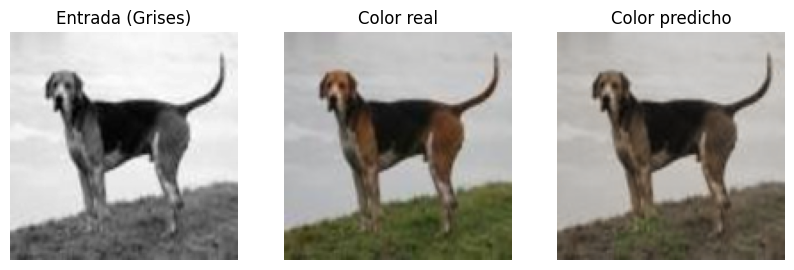

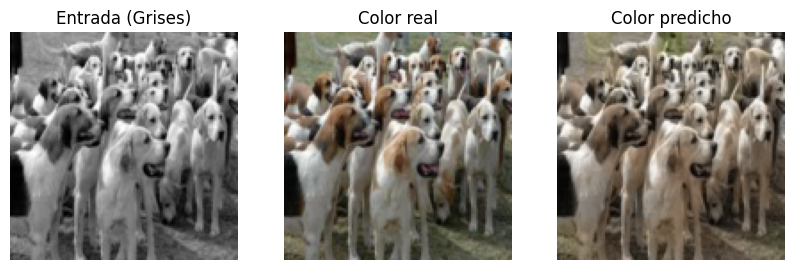

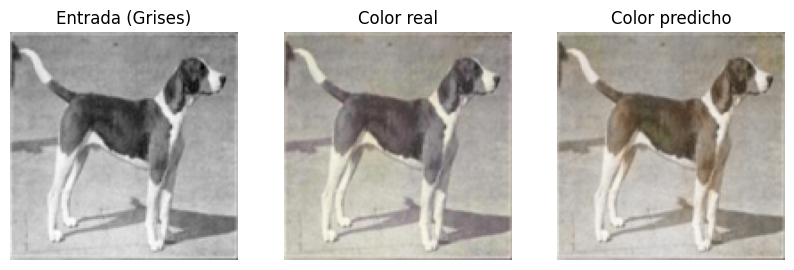

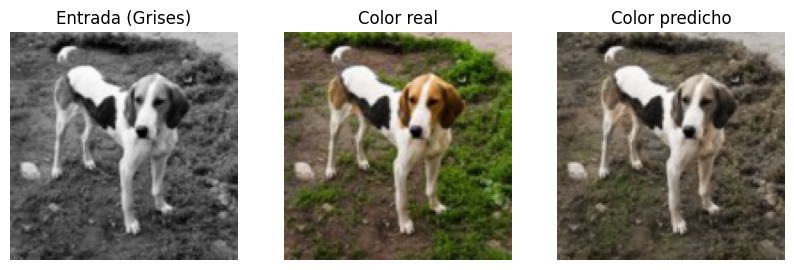

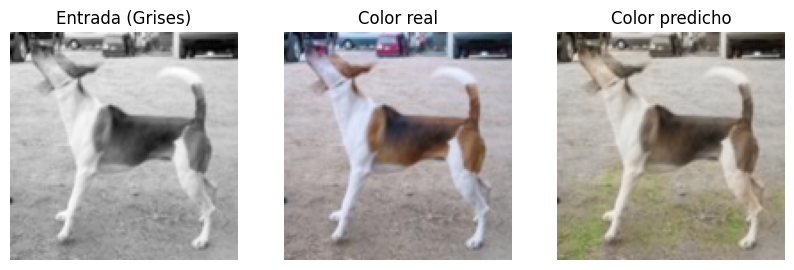

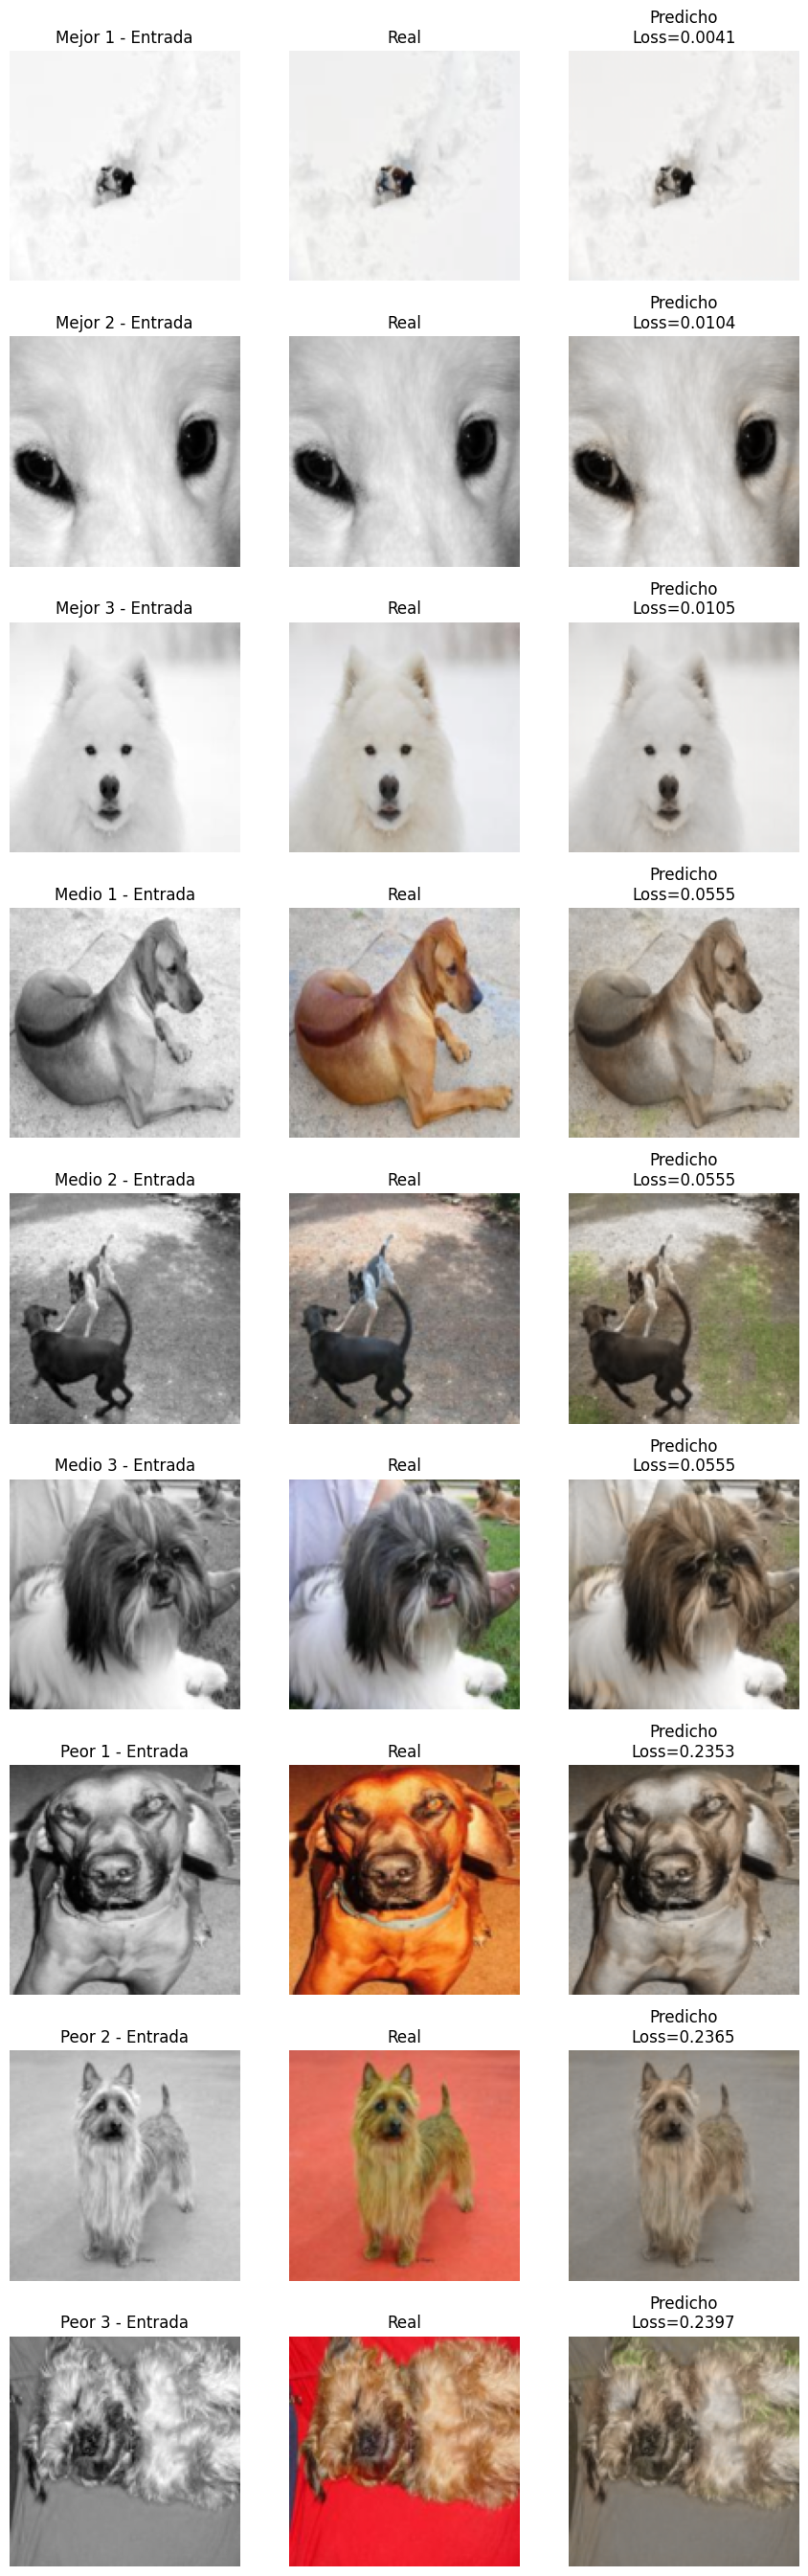

In [19]:
from utils.visualize import visualize_colorization, visualize_ranked_colorizations
# Cargar mejor modelo si hace falta
model = FastColorNet()
model.load_state_dict(torch.load("pesos_entrenados/fastColorNet.pt"))


# Visualizar resultados
visualize_colorization(model, val_loader, num_samples=5)

visualize_ranked_colorizations(model, val_loader, num_each=3, criterion=nn.L1Loss(reduction="none"))


In [14]:
from models.unet import UNetColor


# Configuración del modelo y ruta
model = UNetColor()
save_path = "pesos_entrenados"
save_name = "unetColor.pt"
model_path = Path(save_path) / save_name

train= True  # Cambia a True para forzar el reentrenamiento

# Verificar si ya existe un modelo entrenado
if model_path.exists and not train:
    print(f"✅ Modelo ya entrenado encontrado en '{model_path}'.")
    print("No se vuelve a entrenar para evitar sobreescritura.")
else:
    print("🚀 No se encontró modelo entrenado, iniciando entrenamiento...")
    trainer(
        model,
        train_loader,
        val_loader,
        epochs=10,
        save_path=save_path,
        save_name=save_name
    )
    print(f"💾 Modelo guardado en: {model_path}")

🚀 No se encontró modelo entrenado, iniciando entrenamiento...
Entrenando en: cpu
Usando pérdida: L1Loss


Época 1/10: 100%|██████████| 1129/1129 [07:19<00:00,  2.57it/s, loss=0.0460]


Época 01 | Train Loss: 0.0723 | Val Loss: 0.0690
✅ Nuevo mejor modelo guardado (Val Loss=0.0690)


Época 2/10: 100%|██████████| 1129/1129 [07:48<00:00,  2.41it/s, loss=0.0817]


Época 02 | Train Loss: 0.0685 | Val Loss: 0.0663
✅ Nuevo mejor modelo guardado (Val Loss=0.0663)


Época 3/10: 100%|██████████| 1129/1129 [07:48<00:00,  2.41it/s, loss=0.0378]


Época 03 | Train Loss: 0.0668 | Val Loss: 0.0687


Época 4/10: 100%|██████████| 1129/1129 [07:40<00:00,  2.45it/s, loss=0.1295]


Época 04 | Train Loss: 0.0657 | Val Loss: 0.0649
✅ Nuevo mejor modelo guardado (Val Loss=0.0649)


Época 5/10: 100%|██████████| 1129/1129 [07:40<00:00,  2.45it/s, loss=0.1582]


Época 05 | Train Loss: 0.0649 | Val Loss: 0.0668


Época 6/10: 100%|██████████| 1129/1129 [07:31<00:00,  2.50it/s, loss=0.0254]


Época 06 | Train Loss: 0.0644 | Val Loss: 0.0650


Época 7/10: 100%|██████████| 1129/1129 [07:26<00:00,  2.53it/s, loss=0.0436]


Época 07 | Train Loss: 0.0640 | Val Loss: 0.0623
✅ Nuevo mejor modelo guardado (Val Loss=0.0623)


Época 8/10: 100%|██████████| 1129/1129 [07:26<00:00,  2.53it/s, loss=0.0440]


Época 08 | Train Loss: 0.0636 | Val Loss: 0.0632


Época 9/10: 100%|██████████| 1129/1129 [2:25:40<00:00,  7.74s/it, loss=0.0622]   


Época 09 | Train Loss: 0.0632 | Val Loss: 0.0631


Época 10/10: 100%|██████████| 1129/1129 [19:48<00:00,  1.05s/it, loss=0.0604]   


Época 10 | Train Loss: 0.0629 | Val Loss: 0.0615
✅ Nuevo mejor modelo guardado (Val Loss=0.0615)
Entrenamiento finalizado.
Mejor Val Loss: 0.0615
💾 Modelo guardado en: pesos_entrenados/unetColor.pt


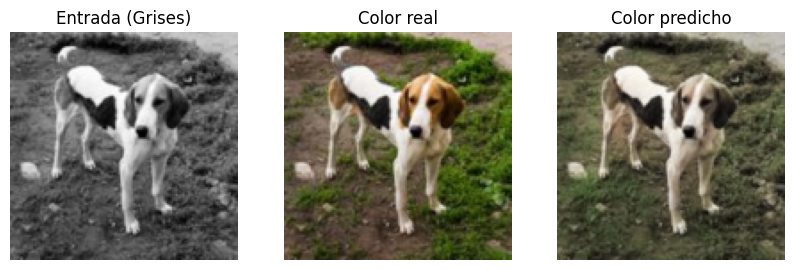

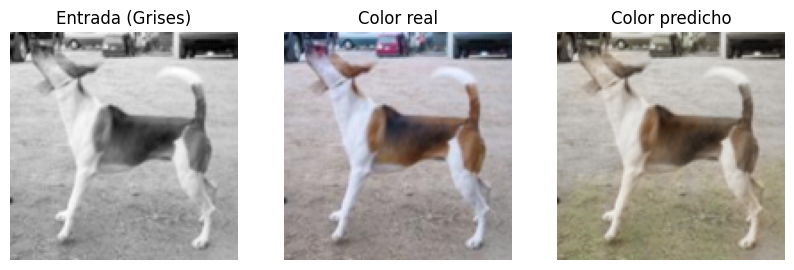

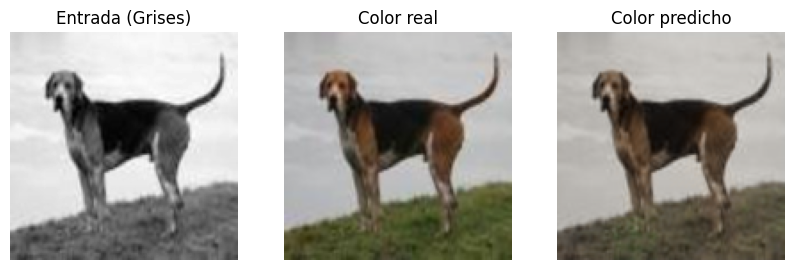

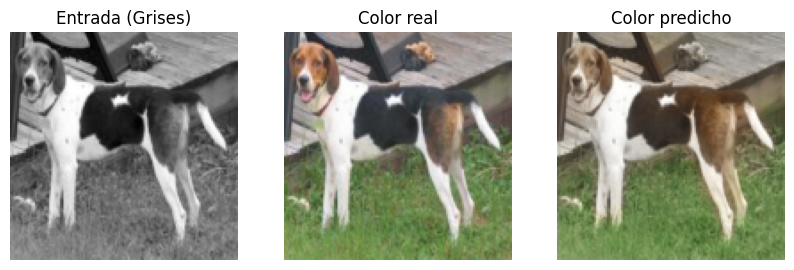

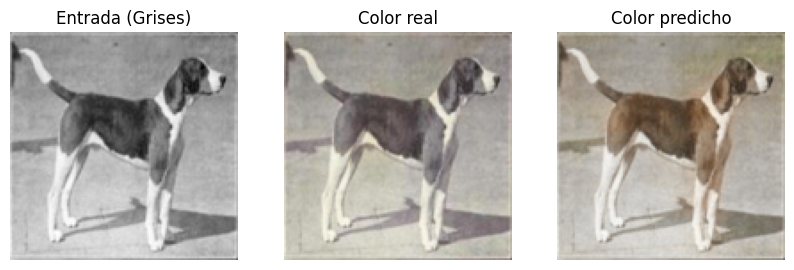

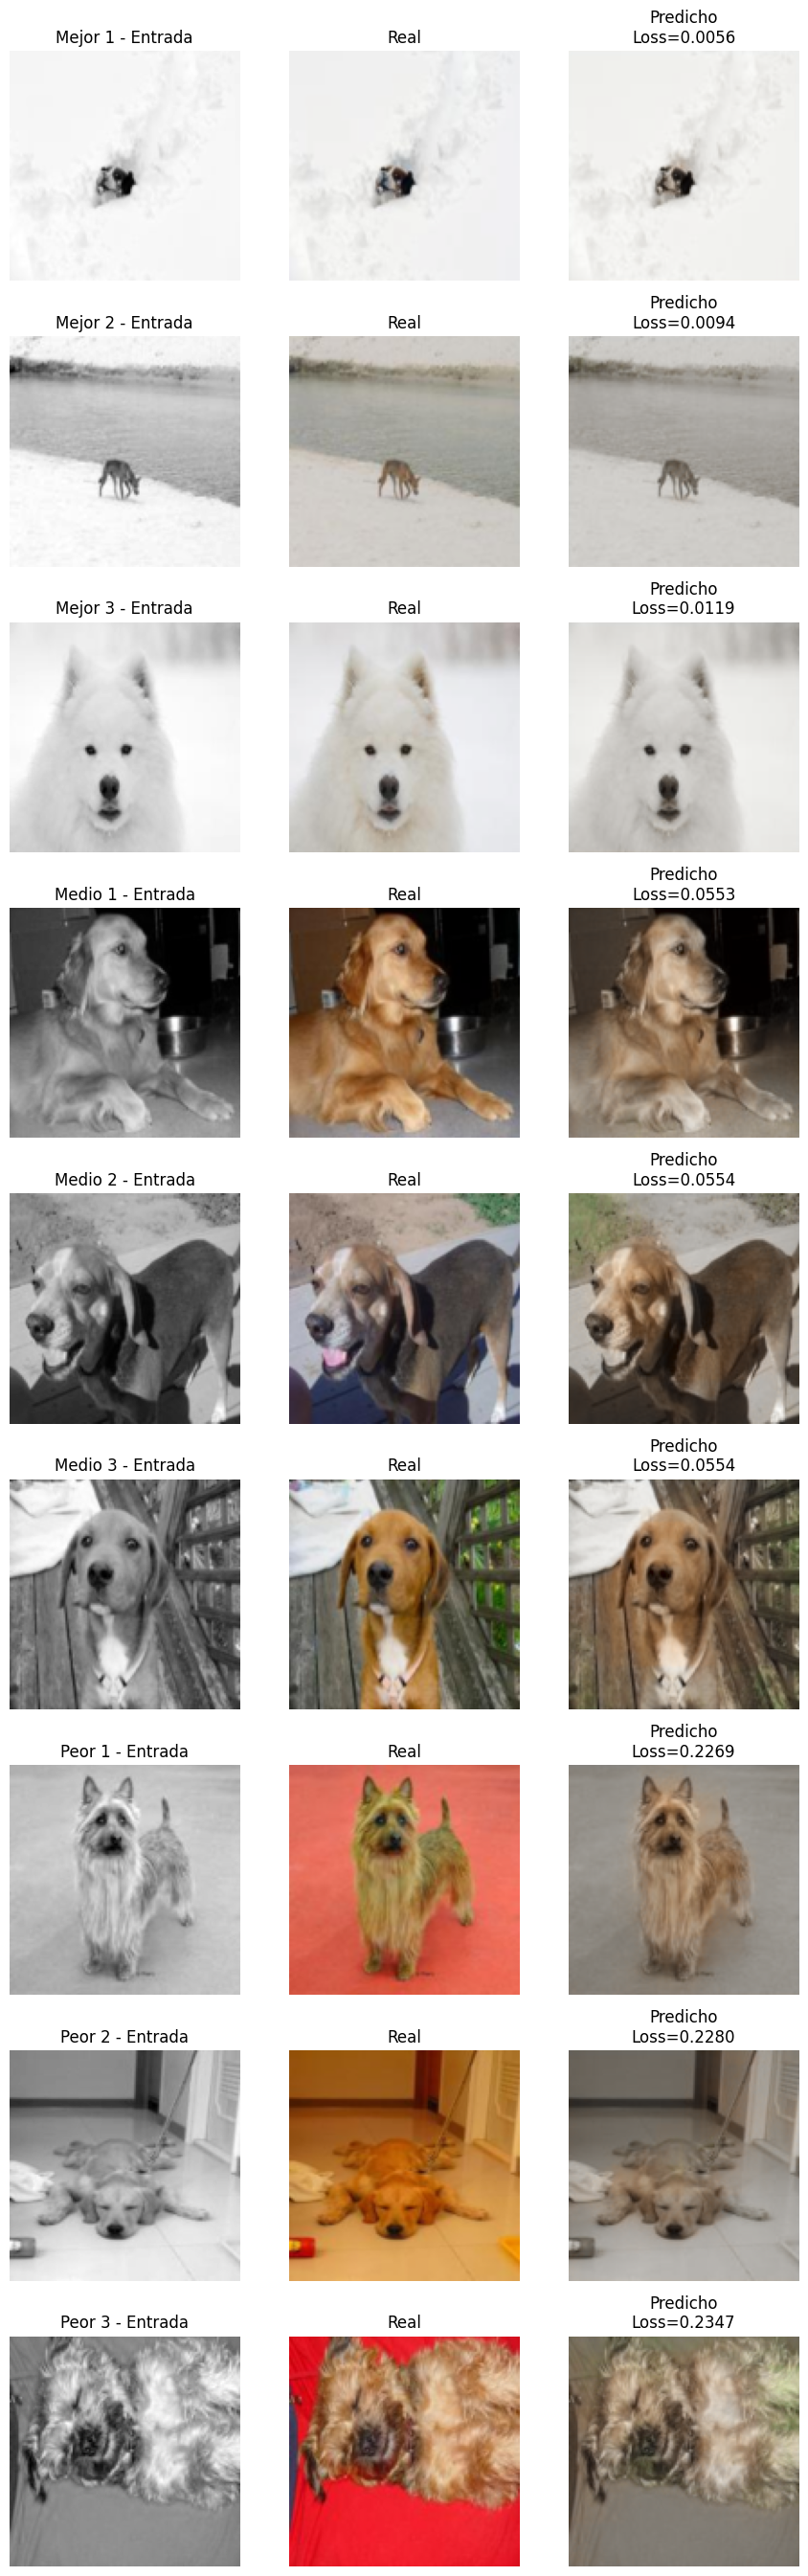

In [20]:
model = UNetColor()
model.load_state_dict(torch.load("pesos_entrenados/unetColor.pt"))


visualize_colorization(model, val_loader, num_samples=5)

visualize_ranked_colorizations(model, val_loader, num_each=3, criterion=nn.L1Loss(reduction="none"))
